# RBA Selected Tables

Worth reading

*  [Updates to Australia's Financial Aggregates](https://www.rba.gov.au/publications/bulletin/2019/mar/updates-to-australias-financial-aggregates.html)

## Set-Up

In [1]:
# standard library imports
from pathlib import Path

# usual data science imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# local imports
import rba_data_capture
from abs_data_capture import (
    get_ABS_meta_and_data,
    get_fs_constants,
)
from plotting import (
    finalise_plot,
    line_plot,
    set_chart_dir,
    clear_chart_dir,
    plot_series_highlighted,
    recalibrate_series,
    plot_covid_recovery,
)

### Some useful constants

In [2]:
TODAY = pd.Timestamp("today")
TOMORROW = TODAY + pd.DateOffset(days=1)

# multi-time-period charts
RECENCY_PERIOD_Y = 5  # years
RECENCY_PERIOD_M = 3  # months
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD_Y, months=RECENCY_PERIOD_M)

V_RECENCY_PERIOD = 365  # days
V_RECENT = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./charts/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

# plotting stuff
plt.style.use("fivethirtyeight")
SOURCE = "Source: RBA"

### List available data tables - but only if needed

In [3]:
if False:
    print(rba_data_capture.get_data_table_labels())

### Clear cache - but only if necessary

In [4]:
if False:
    rba_data_capture.clear_cache()

### Utility functions

In [5]:
def print_last_date(df: pd.DataFrame) -> None:
    print("Last date", df.index[-1])


def print_last_row(df: pd.DataFrame) -> None:
    print("Last date", df.loc[df.index[-1]])

### Labels

In [6]:
if False:
    rba_data_capture.get_data_table_labels()

## Monetary Policy - Official Cash Rate (A2)

### Line charts of Official Cash Rate - different time horizons

In [7]:
# get the data
a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
a2_meta, a2_data = a2 if a2 is not None else (None, None)
print_last_date(a2_data)

Using cached data for "Monetary Policy Changes – A2"
Last date 2023-03-08 00:00:00


In [8]:
a2_meta

A2 RESERVE BANK OF AUSTRALIA – MONETARY POLICY CHANGES,Title,Description,Frequency,Type,Units,Source,Publication date,Series ID
Series ID,,,,,,,,
ARBAMPCCCR,Change in Cash Rate Target,Change in Cash Rate Target (in percentage points),As announced,Original,Per cent,RBA,2023-03-07,ARBAMPCCCR
ARBAMPCNCRT,New Cash Rate Target,The Cash Rate Target As Announced,As announced,Original,Per cent,RBA,2023-03-07,ARBAMPCNCRT


In [9]:
# extract the cash rate series
target = "New Cash Rate Target"
series_id = a2_meta[a2_meta.Title == target].index[0]
ocr_rba = a2_data[series_id]

# remove some early target ranges
ocr_rba = ocr_rba[ocr_rba.index >= pd.Timestamp("1990-08-02")].astype(float)

# update the series to today
if TODAY > ocr_rba.index[-1]:
    last = ocr_rba.iloc[-1]
    ocr_rba[TODAY] = last
    ocr_rba = ocr_rba.sort_index()

# plot full series and recent
ocr_rba = ocr_rba.to_period(freq="D").resample("D").ffill()
line_plot(
    ocr_rba,
    starts=["1993-01-01", RECENT, V_RECENT],
    title="RBA Official Cash Rate",
    drawstyle="steps-post",
    ylabel="Per cent",
    zero_y=True,
    rfooter=f"{SOURCE} A2",
    # show=True,
)

### Highlight the monetary policy tightening cycles

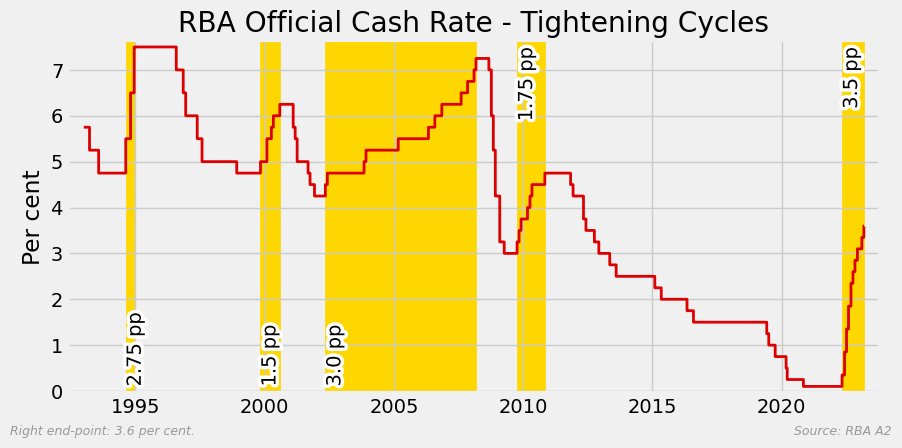

In [10]:
from_date = "1993-01-01"  # Start of RBA inflation-targeting approach
series_93 = ocr_rba[ocr_rba.index >= from_date]

ax = plot_series_highlighted(series_93)
finalise_plot(
    ax,
    title="RBA Official Cash Rate - Tightening Cycles",
    ylabel="Per cent",
    rfooter=f"{SOURCE} A2",
    lfooter=f"Right end-point: {series_93[-1]} per cent. ",
    show=True,
)

## Housing Loan Payments (E13)

In [11]:
e13 = rba_data_capture.get_data("Housing Loan Payments - E13")
e13_meta, e13_data = e13 if e13 is not None else (None, None)

Using cached data for "Housing Loan Payments - E13"


In [12]:
# Note - some data is labeled monthly and some data is labeled quarterly
e13_meta.Frequency.unique()

array(['Quarterly', 'Monthly'], dtype=object)

In [13]:
freqs = {"Quarterly": "Q", "Monthly": "M"}
for index, row in e13_meta.iterrows():
    title = row["Title"]
    unit = row["Units"]
    id = row["Series ID"]
    series_type = row["Type"]
    freq = freqs[row["Frequency"]]
    series = e13_data[id].astype(float).dropna().to_period(freq=freq)
    series, unit = recalibrate_series(series, unit)

    line_plot(
        series,
        starts=RECENT,
        title=title,
        ylabel=unit,
        rfooter=f"{SOURCE} E13",
        lfooter=f"Australia. {series_type}. Endpoint at {series.index[-1]}: {series.iloc[-1]:.02f} {unit}. ",
        # show=True,
    )

## Key market interest rates (F1)

In [14]:
# get the dataset
_ = rba_data_capture.get_data("Interest Rates and Yields – Money Market – Daily – F1")
f1_meta, f1_data = _ if _ is not None else (None, None)
f1_data = f1_data.to_period(freq="D")

# just to see data currency ...
f1_data.loc[f1_data.index[-3:]]

Using cached data for "Interest Rates and Yields – Money Market – Daily – F1"


Series ID,FIRMMCRTD,FIRMMCCRT,FIRMMCRID,FIRMMCRIH,FIRMMCRIL,FIRMMCRIV,FIRMMCRIN,FIRMMCTRI,FIRMMBAB30D,FIRMMBAB90D,FIRMMBAB180D,FIRMMOIS1D,FIRMMOIS3D,FIRMMOIS6D,FIRMMTN1D,FIRMMTN3D,FIRMMTN6D
F1 INTEREST RATES AND YIELDS – MONEY MARKET,,,,,,,,,,,,,,,,,
2023-03-08,3.6,0.25,3.57,3.57,3.57,807,6,126.737438,3.5452,3.6532,3.95,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-09,3.6,NaN,3.57,3.57,3.57,698,5,126.749834,3.5236,3.6261,3.93,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.762231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# get the specific data we want, for the very recent past
wanted = [
    "Cash Rate Target",
    #'Interbank Overnight Cash Rate',
    "EOD 1-month BABs/NCDs",
    # '1-month OIS',  # discontinued December 2022
    # '1-month Treasury Note',
]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .rename({old: neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how="all", axis=1)
    .dropna(how="all", axis=0)
    .ffill()
)

# And plot
title = "Australia - short-term Interest rates"
line_plot(
    plotable_data,
    starts=V_RECENT,
    title=title,
    drawstyle="steps-post",
    ylabel="Per cent",
    rfooter=f"{SOURCE} F1 Daily",
    lfooter="Key: EOD = end of day; "
    "BABs/NCDs = Bank Accepted Bills / Negotiable Certificates of Deposit.",
    # show=True,
)

## Australian Government Bonds - daily rates (F2)

In [16]:
# get the dataset
_ = rba_data_capture.get_data("Capital Market Yields – Government Bonds – Daily – F2")
f2_meta, f2_data = _ if _ is not None else (None, None)
f2_data = f2_data.to_period(freq="D")
f2_data.loc[f2_data.index[-3:]]  # just to see data currency

Using cached data for "Capital Market Yields – Government Bonds – Daily – F2"


Series ID,FCMYGBAG2D,FCMYGBAG3D,FCMYGBAG5D,FCMYGBAG10D,FCMYGBAGID,FCMYGBNT3D,FCMYGBNT5D,FCMYGBNT10D
F2 CAPITAL MARKET YIELDS – GOVERNMENT BONDS,,,,,,,,
2023-03-07,3.4,3.365,3.44,3.685,1.535,3.735,3.84,4.365
2023-03-08,3.49,3.46,3.525,3.745,1.615,3.825,3.925,4.43
2023-03-09,3.475,3.43,3.49,3.71,1.635,3.8,3.89,4.395


In [17]:
# get the specific data we want
bond_yield = f2_meta[
    f2_meta.Title.str.contains("Australian") & f2_meta.Title.str.contains("year")
]
bond_yield_labels = bond_yield.Title.str.replace("Australian Government ", "")
bond_yield_data = f2_data[bond_yield_labels.index]
bond_yield_data.columns = bond_yield_labels

# plot full series and recent
title = "Capital Market Yields - Australian Government Bonds"

line_plot(
    bond_yield_data,
    starts=[None, RECENT, V_RECENT],
    width=1,
    drawstyle="steps-post",
    title=title,
    ylabel="Per cent per annum",
    rfooter=f"{SOURCE} F2 Daily",
    # show=True,
)

In [18]:
T2 = "2 year bond"
T3 = "3 year bond"
inversions23 = bond_yield_data[T3] - bond_yield_data[T2]
inversions23 = -inversions23.where(inversions23 < 0, other=0)
line_plot(
    inversions23,
    starts=[None, RECENT, V_RECENT],
    title="Capital Market Yield Inversions [(3-year - 2-year) * -1]",
    ylabel="% points difference",
    rfooter=f"{SOURCE} F2 Daily",
    lfooter="Australian Government Bonds. ",
    # show=True,
)

## Growth in credit aggregates (D1)

In [19]:
data_label = "Growth in Selected Financial Aggregates – D1"
_ = rba_data_capture.get_data(data_label)
d1_meta, d1_data = _ if _ is not None else (None, None)
d1_data = d1_data.to_period(freq="M")
print_last_date(d1_data)

Using cached data for "Growth in Selected Financial Aggregates – D1"
Data
Last date 2023-01


In [20]:
chart_set = [
    "Credit; Housing; Monthly growth",
    "Credit; Owner-occupier housing; Monthly growth",
    "Credit; Investor housing; Monthly growth",
    "Credit; Other personal; Monthly growth",
    "Credit; Business; Monthly growth",
    "Credit; Total; Monthly growth",
]

for label in chart_set:
    name = d1_meta[d1_meta.Title == label].index[0]
    type = d1_meta[d1_meta.Title == label].Type.iloc[0]
    series = d1_data[name]

    line_plot(
        series,
        starts=[None, RECENT],
        axhline={"y": 0, "c": "#888888", "lw": 0.75}
        if (series.min() < 0 and series.max() > 0)
        else None,
        title=label,
        ylabel="Per cent",
        rfooter=f"{SOURCE} D1",
        lfooter=type,
        # show=True,
    )

## Money supply and the velocity of money (D3)

According to the Quantity Theory of Money:

$$ MV=PT $$

Where ($M$) is money supply, ($V$) is the velocity of circulation (the number of times 
money changes hands), ($P$) is the average price level, and ($T$) is the volume of transactions of goods and services. Of note: $PT$ is the same as nominal GDP. Therefore:

$$V=\frac{nGDP}{M}$$


### Money supply

In [21]:
# Get DataFrame for the M1 and M3 money supply
_ = rba_data_capture.get_data("Monetary Aggregates – D3")
d3_meta, d3_data = _ if _ is not None else (None, None)
d3_data = d3_data.to_period(freq="M")

Using cached data for "Monetary Aggregates – D3"


In [22]:
# plot Money Supply
to_get = ["Currency: Seasonally adjusted", "Money base", "M1", "M3", "Broad money"]
gotten = {t: d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
m_units = {t: d3_meta[d3_meta["Title"] == t].Units[0] for t in to_get}

for title, series in gotten.items():
    series = series.dropna().astype(float)
    series, m_unit = recalibrate_series(series, m_units[title])
    series.name = title
    chart_title = f"{title} - Money Supply"

    aux_kwargs = {}
    aux_kwargs["start_r"], aux_kwargs["end_r"] = (
        ("2016-05-01", "2019-05-01") if title == "M1" else ("2017-01-01", "2020-01-01")
    )

    plot_covid_recovery(
        series,
        **aux_kwargs,
        title=chart_title,
        tags="COVID",
        ylabel=m_unit,
        rfooter=f"{SOURCE} D3",
        # show=True,
    )

    line_plot(
        series,
        starts=[None, TEN_YEARS],
        title=chart_title,
        ylabel=m_unit,
        rfooter=f"{SOURCE} D3",
        # show=True,
    )

    line_plot(
        series,
        starts=[None, TEN_YEARS],
        title=chart_title,
        ylabel=f"{m_unit} (log scale)",
        rfooter=f"{SOURCE} D3",
        yscale="log",
        # show=True,
    )

### Nominal GDP

In [23]:
if False:
    # get nominal GDP from the ABS National Accounts
    catalogue_id = "5206"
    abs_dict = get_ABS_meta_and_data(catalogue_id)
    source, _, META_DATA = get_fs_constants(catalogue_id)
    meta = abs_dict[META_DATA]

    table = "3"  # GDP expenditure in current prices
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    data_item = "GROSS DOMESTIC PRODUCT ;"
    selected = meta[
        (meta.Table == table)
        & (meta["Series Type"] == series_type)
        & meta["Data Item Description"].str.contains(data_item)
    ]
    assert len(selected) == 1
    units = selected.Unit.iloc[0]
    series_id = selected["Series ID"].iloc[0]
    yearly_nom_gdp = (
        data[series_id].rolling(4).sum().dropna()
    )  # sum to annual nominal GDP
    yearly_nom_gdp, units = recalibrate_series(yearly_nom_gdp, units)

### Velocity of money

In [24]:
# still to do

## Watermark

In [25]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Mar 10 2023 13:19:25

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pandas    : 1.5.3
matplotlib: 3.7.1
numpy     : 1.24.2

Watermark: 2.3.1



In [26]:
print("Done")

Done
